In [ ]:
# bilgisayar ve google collab için gpu kullandığımdan emin oluyorum
import torch
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# bazen gpu torchta takılıyor onu sıfırlamak için küçük bir kod
'''
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()
'''

'\n!pip install numba\n\nfrom numba import cuda \ndevice = cuda.get_current_device()\ndevice.reset()\n'

In [ ]:
from huggingface_hub import login

# bazı modellerde erişim problemi yaşadığımdan buraya kendi hugging face api key'imi yazdım ancak projeyi iletirken sildim
login("API_KEYIM")

In [ ]:
# kategorileri eşleştirmek istersem diye bir sözlük yaptım kategorilerden
category_mapping = {
    0: "siyaset",
    1: "dunya",
    2: "ekonomi",
    3: "kultur",
    4: "saglik",
    5: "spor",
    6: "teknoloji"
}

In [ ]:
# veri setini bölme, labelları belirleme ve kütüphaneler ile ilgili işlemleri yaptım trsav1 için de 150k'dan 5k ya indirdim
!pip install datasets
from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

ttc4900 = load_dataset("savasy/ttc4900")
trsav1 = load_dataset("maydogan/TRSAv1")

ttc4900_split = ttc4900['train'].train_test_split(test_size=0.2, seed=42)
train_ttc4900 = ttc4900_split['train']
test_ttc4900 = ttc4900_split['test']
print(type(test_ttc4900[0]['category']))

trsav1_sample = trsav1['train'].select(range(5000))
trsav1_split = trsav1_sample.train_test_split(test_size=0.2, seed=42)
train_trsav1 = trsav1_split['train']
test_trsav1 = trsav1_split['test']

ttc4900_candidate_labels = ["0", "1", "2", "3", "4", "5","6"]
trsav1_candidate_labels = ["Positive", "Neutral", "Negative"]

models = {
    "YTU-CE-COSMOS | Turkish Llama": "ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1",
    "GOOGLE | Gemma 2":"google/gemma-2-9b-it",
    "ASAFAYA | Kanarya":"asafaya/kanarya-750m",
    "BIG SCIENCE | Bloom":"bigscience/bloom-560m",
    "Cohere AI | Aya Expanse": "CohereForAI/aya-expanse-8b",
    "Wiro AI | LLM": "WiroAI/wiro-llm-tr-v0.1",
    "Trendyol | LLM": "Trendyol/Trendyol-LLM-8b-chat-v2.0",
    "KOC Digital | LLM": "KOCDIGITAL/Kocdigital-LLM-8b-v0.1",
    "Veri US | LLM": "VeriUS/VeriUS-LLM-8b-v0.2"

}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.70k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.51M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4900 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/708 [00:00<?, ?B/s]

TRSAv1.csv:   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

<class 'int'>


In [ ]:
# burada promptları oluştrudum ilk önce sadece examplesı kullandım daha sonra use_prompts diye bir değişken ekledim bu değişken ile standart promptları iyileştirdim ve daha iyi çıktılar aldım
def generate_prompt(shot, dataset_name,use_prompts = True):
    examples = {
        "ttc4900": [
            ("kuran ı kerim yakan kişi gözaltına alındı sosyal paylaşım sitesi facebook taki profiline kurban_bayramı nın birinci günü kuran ı kerim yakarken çektirdiği fotoğrafı yükleyen predrag çosoviç adlı sırp başkent belgrad da gözaltına alındı belgrad teknoloji suçları özel yetkili savcısı branko stamenkoviç aa muhabirine yaptığı açıklamada polisin predrag çosoviç adlı kişinin facebook profiline kuran ı kerim i yakarken çekilmiş bir fotoğrafı yüklediği bilgisine 29 ekim de ulaştığını belirtti stamenkoviç söz konusu kişi dini ve milli duyguları incitme suçunu işlediğini fotoğrafları yayımlayarak kanıtlamıştır ilgili şahsın 30 ekim de kimliği belirlendi ve kendisi gözaltına alındı dedi belgrad bölge mahkemesi nin savcılığın talebi üzerine 48 saat gözaltı süresi verdiğini ifade eden stamenkoviç ilgili şahsın işlediği suç geniş kitlelerin incinmesine yol açan bir suçtur kendisiyle ilgili soruşturma ve diğer gerekli işlemler yürütülüyor diye konuştu bu arada çosoviç in facebook profiline kuran ı kerimi yakarken yüklenen fotoğrafın yanı sıra birinci ve ikinci dünya savaşlarında onbinlerce insanın katledilmesinden sorumlu radikal sırp çetnik hareketinin simgelerin yer aldığı giysilerle çekilmiş fotoğraflarının da bulunduğu belirtildi facebook taki sayfasına kurban_bayramı hakkında yorum da yazan çosoviç in mesajında sırbistan daki müslümanlara türk dediği ve gelecek bayramı görmeyeceklerini ümit ettiğine yönelik ifadeler yer alıyor aa", "1"),
            ("merkez in ihalesine 800 milyon liralık teklif tcmb 3 aralık vadeli repo ihalesiyle piyasaya 800 milyon lira verdi ihaleye 800 milyon liralık teklif geldi merkez_bankası bugün düzenlediği 3 aralık vadeli miktar bazlı repo ihalesi ile piyasaya 800 milyon lira verdi ihaleye 800 milyon liralık teklif geldi ihalede en düşük ortalama ve en yüksek basit faiz 5 75 olurken en düşük ortalama ve en yüksek bileşik faiz ise yüzde 5 92 seviyelerinde gerçekleşti", "2"),
            ("nil koleji obeziteyle mücadele başlattı diyarbakır da faaliyet gösteren özel nil ilköğretim okulu çağın hastalığı olarak kabul edilen obeziteyle mücadele başlattı okul yönetimi bilim adamlarının günümüzde ülkelerin en önemli sağlık sorunu olarak tanımladığı hastalığa karşı öğrenci ve velilerle işbirliği yaptı özel nil ilköğretim okulu müdürü ali pehlivan yaptığı açıklamada abur cubur yeme başta olmak üzere dengesiz tek tip beslenme doğal olmayan ürünlerle beslenme öğün atlama ve porsiyonların büyümesi gibi faktörlerin obezitenin nedenleri arasında yer aldığını söyledi beslenmenin anne karnından başlayarak yaşamın sonlandığı ana kadar devam eden vazgeçilmez bir ihtiyaç olduğunu hatırlatan pehlivan sağlıklı bir yaşam sürdürmek için alınan enerji ile harcanan enerjinin dengede tutulması gerekmektedir biz de okul olarak bir dizi önlem aldık yaşamın ve okulun içerisine aktivite kattık günlük bedensel aktiviteleri ders içi ve ders dışı faaliyetlere yaydık özellikle yemekten sonra yürüyüş ve kondisyon aletleriyle teneffüslerde kalori yakmanın yolunu açtık yemek menülerini çocukların ihtiyaç duyacakları kalori miktarına göre ayarladık okul kantininde gazlı ve zararlı meşrubat cips gibi ürünlerin satışını engelledik zaman içerisinde aldığımız önlemlerin neticesi ortaya çıkacaktır sağlıklı bir nesil mutlu bir aile sağlıklı bir toplum hedeflemekteyiz dedi ali pehlivan dicle_üniversitesi ile de işbirliği yaparak bilimsel anlamda yardım alma süreci takip etme ve bununla ilgili öğrenci ve velilere seminer vermenin de programlarında olduğunu kaydetti cha", "4"),
            ("örgütler ölümcül eylemlerde hasta ve yaşlıları kullanıyor istanbul_gaziosmanpaşa  da biri anne karnında iki çocuk babası polis memuru mücahit_daştan  ı şehit eden nurgül acar  ın kanser hastası olduğunun ortaya çıkması hasta ve yaşlı teröristleri baskıyla ölüme gönderen terör örgütlerinin çirkin yüzünü bir kez daha ortaya koydu son aylarda dhkp c tarafından gerçekleştirilen eylemlere katılan birçok militanın ölümcül hasta olması bu iddiaları güçlendirdi dhkp c  nin yanı sıra pkk da hastalanan teröristleri canlı bomba olmaya zorladığı istatistiklere yansıdı göğsünün biri alınmış hasta trabzon  da tayad eylemi sırasında linç edilmekten polis tarafından kurtarılan nurgül acar 7 yıl sonra faturasını ödedikten sonra görev yerine dönen mücahit_daştan isimli polis memurunu şehit etti yenibosna polis merkezi  ne nabiha arıcı ile birlikte saldıran ancak polisin karşılık vermesi sonucu olay yerinden kaçan acar  ın örgütten gelen baskılar nedeniyle gördüğü ilk polise saldırdığı iddia ediliyor saldırının ardından gaziosmanpaşa ilçe emniyet_müdürlüğü ekipleri tarafından gözaltına alınan acar  ın yapılan muayenesinde kanser hastası olduğu ortaya çıktı göğsünün biri alınan acar  ın kanser hastası olması akıllara terör örgütlerinin canlı bomba eylemlerinde hasta ve hayattan beklentisi kalmayan teröristleri kullanmasını getirdi terör örgütlerinin ölüme gönderdiği hasta örgüt mensupları arasında taksim bombacısı da bulunuyor kimi kanser kimi beyin tümörü ibrahim çuhadar kanser tedavisi görüyordu sultangazi 75 yıl polis merkezi amirliği  ne yapılan canlı bomba saldırısında polis memuru bülent özkan şehit oldu 5 kişi de yaralandı saldırıyı dhkp c  li ibrahim çuhadar  ın gerçekleştirdiği tespit edildi terör örgütü üyesi olmaktan poliste kaydı olan çuhadar  ın kanser hastası olduğu belirlendi nurgül acar meme kanseri olduğu belirlenen nurgül acar  ın yenibosna 75 yıl polis merkezine saldırırken yanında olan arkadaşı nabiha arıcı  nın da hasta olduğu belirlendi polisten kaçarken yakalanan arıcı  nın böbreklerinden ameliyat olduğu öğrenildi aynı eyleme katılan iki teröristin de hasta olması dikkat çekti sakin g  terörle_mücadele_şube_müdürlüğü tarafından eyüp ilçesinde yapılan operasyonda 4 kilo amanyum nitrat ile yakalanan sakin g  nin depresyon ilaçları kullandığı tespit edildi eski dhkp c  li asuman akça  yı vuran selçuk a psikolojik sorunları nedeni ile askerlik görevini tamamlayamadığı öğrenildi servet gözmen  avcılar denizköşkler mahallesi reşitpaşa caddesinde para çeken polis memuru sabri yiğit  e silahlı saldırıda bulunan servet gözmen yakalandıktan sonra sağlık kontrolünden geçirildi gözmen  in vücudunda jilet izleri olduğu görüldü taksim bombacısı behçet hastası eylemlerde hastaları kullanan bir başka örgüt ise pkk taksim meydanında görev yapan çevik_kuvvet minibüsüne yönelik canlı bomba eylemi yapan pkk  lı terörist vedat acar  ın da behçet hastası olduğu ortaya çıkmıştı derveş şino kod adını kullanan acar  ın hastalığı iyice ilerlediği için örgüt kamplarında balık tutmak odun toplamak ve yemek yapmak gibi işleri yaptığı ortaya çıkmıştı hastalığı nedeni ile örgüt içinde  hasta vanlı  olarak çağrılan vedat acar bu nedenle canlı bomba eylemine gönderildiği iddia ediliyor kartepe feribotunu 24 mürettebat ve yolcusu ile birlikte kaçırılan ve yapılan operasyonda ölü ele geçirilen mensur güzel  inde hasta olduğu ortaya çıkmıştı ölü ele geçirildikten sonra otopsisi yapılan güzel  in beyninde ur çıkmıştı hasta militan infaz edilmişti terör örgütleri hastaları kendileri yük olarak görüyor istenilen eylemi yapmayan hasta teröristler bir anda ortadan kayboluyor tedavi için hastaneye gönderildiği açıklanan teröristin aslında infaz edildiğini ise tüm örgüt biliyor geçtiğimiz aylarda örgütten kaçarak güvenlik güçlerine teslim olan e b verdiği ifadede hasta teröristlerin öldürüldüğünü söylemişti terör örgütlerinin canlı bomba eylemlerinde ve güvenlik güçlerine yönelik saldırılarda hasta teröristleri kullanması istihbarat raporlarını da yansıdı örgütlerin hayattan beklentisi kalmamış sabıkalı ve hasta teröristleri eylemlerde kullanılması için talimat verdiği belirtiliyor","0"),
            ("mesut imaj yaptı real_madrid in türk asıllı süperstarı mesut_özil yaptığı değişiklikle dikkatleri üzerine çekti real_madrid in başarılı hücum oyuncusu mesut_özil özellikle ispanya ya transfer olduktan sonra çok daha başarılı imajlarıyla hayranlık uyandırıyor dünyadaki genç kızların hayranlığını uyandırıyor mesut_özil yine bir imaj değişikliğine gitti saçlarını oldukça kısa kestiren mesut resmi facebook sayfasından yayınladığı fotoğrafla yeni imajını hayranlarıyla paylaştı mesut_özil e özellikle genç kızlardan yine hayranlık mesajları yağıyor real_madrid e ilk geldiği günlerden beri uzun saçlı görmeye alıştığımız mesut kariyerinin ilk yıllarında bile bu kadar kısa saçlı olmamıştı gelsenkirchen de 15 ekim 1988 doğan mesut_özil 24 yaş gününü kutlamaya hazırlanıyor","5")
        ],
        "trsav1": [
            ("Şu cihazı nerden buldular bilmiyorum ama iyi ki bulmuslar, almayan bin pişman olur. Ilk kullanimda farki görüyorsunuz, bununla birlikte bioderma ürünleri harika oluyor. Iyi ki almisim seni Xiaomi ❣😌", "Positive"),
            ("Ürünü çok övdükleri için aldım. Henüz bir kere denedim saçlarımı aşırı sertleştirdi yıkadıktan sonra açmak için bir saat uğraştım. Sanırım biraz daha kullandıktan sonra sonucunu alabileceğim", "Negative"),
            ("Benım saclarımın dogal hali acık kumral ,saç acıcıyla actım bıraz daha dah sarı oldu ve küllü haline dondurmek için kullandım bu şampuanı ancak fark goremıyorum ne yazıkki evdekilerde yok diyor . Birkac kez tekrar deneyecegım fark olursa yorum yazarım", "Negative"),
            ("Aynı serinin hem krem hem güneş koruyucusunu kullanıyor çok seviyorum ama bu üründe atlanan ciddi bişey var ürün yağ bazlı karma yağlı ciltli biriyim sivilcelenme yaşadım belki süperdir ama uzun sürede kullanamayacağım için bunu göremiyor bilemiyorum keşke kuru cilde uygun denseydi","Negative"),
            ("19 gündür kullanıyorum. Bendeki etkilerine gelirsek öncelikle kendimden bahsedeyim daha yararlı olur.29 yasındayım. Cildim karma sivilce ve siyah noktaya meyilli ve t bolgemde gozeneklerim biraz fazlaca. ürünün etkilerine gelirsek cildimde aydınlanma oldu, gozenklerimi kücülttü ve ufak ufak kücük sivilvelerim vardı onlar bayağı azaldı ve en onemlisi göz cevremde ince cizgilerimi actı. ama ben ürünü tek kullanmadim haftada 2 kere peeling bir kere kil.maskesi ve birde yumurta akı maskesini mutlaka yapıyorum ve en önemlisi belki göz cevremdeki ince cizgilerimi acmasında etkili olmustur saf zeytinyagı hafta da üc kere tüm yüzüme sürüyorum.","Positive")
        ],
    }
    if use_prompts == True:
      example_prompts = "\n".join(
          f"### Örnek Metin:  {ex[0]}\n### Örnek Çıktı:  {ex[1]}"
          for ex in examples[dataset_name][:shot]
      )

      prompt = f"""Aşağıda bir görevi açıklayan talimat bulunmaktadır. Talimatı yeterince sağlayan bir çıktı yaz.

      ### Talimat:
      Lütfen verilen metnin içeriğine uygun olarak, uygun sınıflandırmayı (etiketi) belirtin. Sadece bir adet çıktı belirt ve başka bir çıktı yazma.

      {example_prompts}

      ### Çıktı:
      """
      return prompt
    prompt = "\n".join(
          f"{ex[0]}\n{ex[1]}"
          for ex in examples[dataset_name][:shot]
      )
    return prompt

In [ ]:
# örneklere baktım
print(generate_prompt(3,"ttc4900",use_prompts = False))
print(generate_prompt(0,"ttc4900",use_prompts = False))
print(generate_prompt(5,"ttc4900",use_prompts = False))

kuran ı kerim yakan kişi gözaltına alındı sosyal paylaşım sitesi facebook taki profiline kurban_bayramı nın birinci günü kuran ı kerim yakarken çektirdiği fotoğrafı yükleyen predrag çosoviç adlı sırp başkent belgrad da gözaltına alındı belgrad teknoloji suçları özel yetkili savcısı branko stamenkoviç aa muhabirine yaptığı açıklamada polisin predrag çosoviç adlı kişinin facebook profiline kuran ı kerim i yakarken çekilmiş bir fotoğrafı yüklediği bilgisine 29 ekim de ulaştığını belirtti stamenkoviç söz konusu kişi dini ve milli duyguları incitme suçunu işlediğini fotoğrafları yayımlayarak kanıtlamıştır ilgili şahsın 30 ekim de kimliği belirlendi ve kendisi gözaltına alındı dedi belgrad bölge mahkemesi nin savcılığın talebi üzerine 48 saat gözaltı süresi verdiğini ifade eden stamenkoviç ilgili şahsın işlediği suç geniş kitlelerin incinmesine yol açan bir suçtur kendisiyle ilgili soruşturma ve diğer gerekli işlemler yürütülüyor diye konuştu bu arada çosoviç in facebook profiline kuran ı ke

In [ ]:
# burada daha önceki ödevden öğrendiğim şeyleri geliştirdim ve çok daha iyi bir sonuç aldım. öncelikle testleri yaparken çok beklememek adına test only diye bir değişken oluştrudum bu değişkeni True olarak gönderirsem
# tüm veriyi dönmeden önce 100 verilik bir döngü yapıp testlerimi hızlı yapabiliyorum. kodu yazarken hatalarla karşılaştırdığımdan bu işimi çok hızlandırdı. ikinci yaptığım işlem ise normalde tüm kullandığım LLM, embedding gibi
# modelleri direkt olarak yüklüyordum bu sefer her döngüde modeli yüklüyorum ve işlemlerimi bitirince del komutu ile memoryden siliyorum bu şekilde batch sayısını çok fazla düşürmeden veya gpu memory hatası ile karşılaşmadan
# işlem yapabiliyorum. standart batch boyutunu 1000 yani tek döngü olarak belirledim ancak bazı testlerimde bunu 500'e çekmek gerekti bu sayede işlemleri yapabildim eğer test edecekseniz ideal batch 500 olacaktır. bu şekilde
# yaklaşık 40gb vramlik bir google collab ortamında rahatlıkla tüm llm'ler işlenebiliyor. yine promptlar için de burada ilgili promptları çekiyor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from numba import cuda

def evaluate_model(model_name, model_tag, test_data, labels, shot_type, test_only=False,batch = 1000):
    torch.cuda.empty_cache()
    classifier = pipeline("zero-shot-classification", model=model_tag, device=0)
    predictions = []
    prompts = {
        "Zero-shot": generate_prompt(0,dataset_name),
        "3-shot": generate_prompt(3,dataset_name),
        "5-shot": generate_prompt(5,dataset_name),
    }
    prompt = prompts[shot_type]


    if test_only:
        test_data = test_data.select(range(min(100, len(test_data))))


    for i in range(0, len(test_data), batch):
        batch = test_data[i:i + batch]
        if dataset_name == "ttc4900":
          batch_texts = batch['text']
        elif dataset_name == "trsav1":
          batch_texts = batch['review']
        batch_prompts = [f"{prompt}\n\nMetin: {text}\nÇıktı:" for text in batch_texts]
        batch_results = classifier(batch_prompts, labels)
        # tahminlemeler
        for result in batch_results:
            if 'labels' in result and len(result['labels']) > 0:
                predictions.append(result['labels'][0])
            else:
                predictions.append("Unknown")

    # asıl labellar
    if dataset_name == "trsav1":
      true_labels = [item['score'] if 'score' in item else "Unknown" for item in test_data]
    elif dataset_name == "ttc4900":
      true_labels = [item['category'] if 'category' in item else "Unknown" for item in test_data]

    true_labels = [str(label) for label in true_labels]
    predictions = [str(pred) for pred in predictions]

    #
    if len(predictions) != len(true_labels):
        raise ValueError(f"Inconsistent number of samples: predictions={len(predictions)}, true_labels={len(true_labels)}")
    del(classifier) # GPU İÇİN ÖNEMLİ OLUYOR

    # metrikleri hesaplama (sistem arada hata verirse diye kaçırmamak için print de ediyorum)
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    print("accuracy: ", accuracy, "precision: ", precision, "recall: ", recall, "f1: ", f1)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# dataları yükleme ve test modu değişkeni
results = {}
test_mode = False
datasets = {
    "ttc4900": (test_ttc4900, ttc4900_candidate_labels),
    "trsav1": (test_trsav1, trsav1_candidate_labels)
}


In [ ]:
# tüm işlemleri başlatan code bloğu bu işlewmler uzun sürecektir.
for dataset_name, (test_data, labels) in datasets.items():
    results[dataset_name] = {}
    print(f"\nEvaluating on dataset: {dataset_name}")
    for model_name, model_tag in models.items():
        print(f"  Evaluating {model_name}...")
        results[dataset_name][model_name] = {
            "Zero-shot": evaluate_model(model_name, model_tag, test_data, labels, "Zero-shot", test_only=test_mode),
            "3-shot": evaluate_model(model_name, model_tag, test_data, labels, "3-shot", test_only=test_mode),
            "5-shot": evaluate_model(model_name, model_tag, test_data, labels, "5-shot", test_only=test_mode),
        }

In [25]:
# çıktıları yazdırma
for dataset_name, dataset_results in results.items():
    print(f"\nResults for dataset: {dataset_name}")
    for model_name, metrics in dataset_results.items():
        print(f"\n  {model_name} Results:")
        for shot_type, values in metrics.items():
            print(f"    {shot_type.capitalize()}:")
            for metric, value in values.items():
                print(f"      {metric.capitalize()}: {value:.4f}")


Results for dataset: ttc4900

  YTU-CE-COSMOS | Turkish Llama Results:
    Zero-shot:
      Recall: 0.2479
      Accuracy: 0.2479
      Precision: 0.2600
      F1: 0.1508
    3-shot:
      Recall: 0.2585
      Accuracy: 0.2585
      Precision: 0.2014
      F1: 0.1845
    5-shot:
      Recall: 0.1799
      Accuracy: 0.1799
      Precision: 0.0740
      F1: 0.0862

  GOOGLE | Gemma 2 Results:
    Zero-shot:
      Recall: 0.2391
      Accuracy: 0.2391
      Precision: 0.1719
      F1: 0.1681
    3-shot:
      Recall: 0.2898
      Accuracy: 0.2898
      Precision: 0.2236
      F1: 0.2075
    5-shot:
      Recall: 0.2111
      Accuracy: 0.2111
      Precision: 0.0841
      F1: 0.1002

  ASAFAYA | Kanarya Results:
    Zero-shot:
      Recall: 0.2564
      Accuracy: 0.2564
      Precision: 0.2706
      F1: 0.1557
    3-shot:
      Recall: 0.2643
      Accuracy: 0.2643
      Precision: 0.2092
      F1: 0.1904
    5-shot:
      Recall: 0.1888
      Accuracy: 0.1888
      Precision: 0.0787
    

In [26]:
# görselleştirme için df
import pandas as pd
import matplotlib.pyplot as plt
performance_data = []
for dataset_name, dataset_results in results.items():
    for model_name, metrics in dataset_results.items():
        for shot_type, values in metrics.items():
            performance_data.append({
                "Dataset": dataset_name,
                "Model": model_name,
                "Shot Type": shot_type,
                "Accuracy": values["accuracy"],
                "Precision": values["precision"],
                "Recall": values["recall"],
                "F1 Score": values["f1"]
            })

performance_df = pd.DataFrame(performance_data)

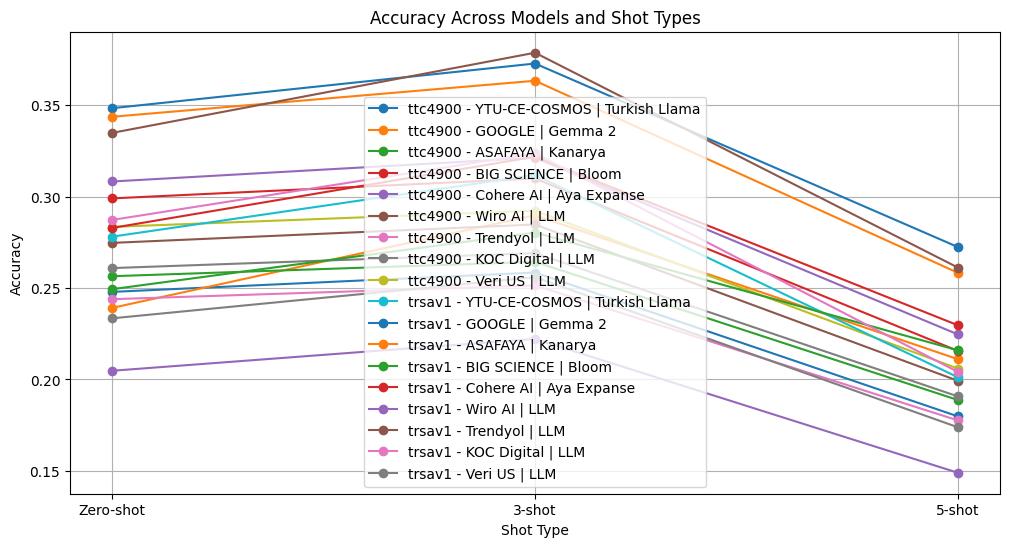

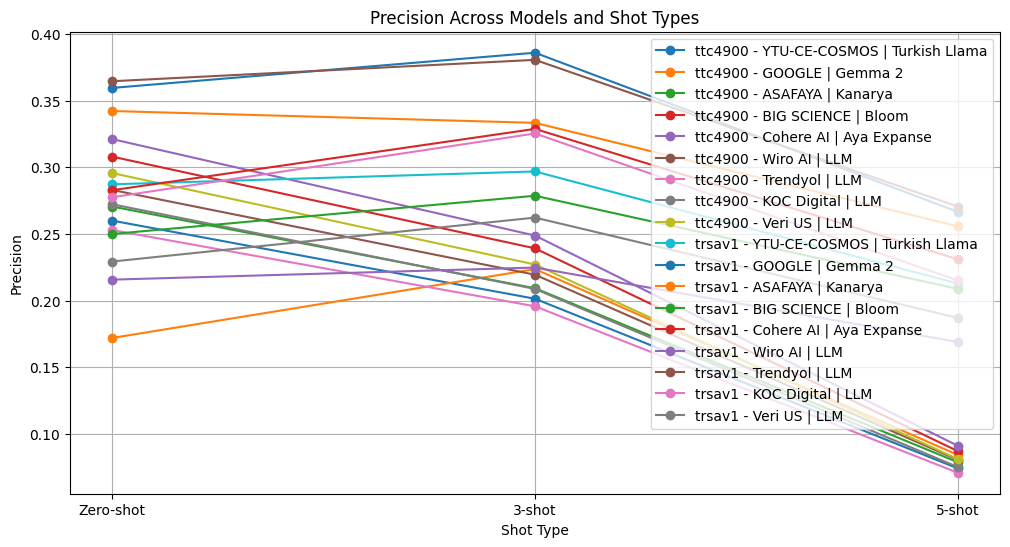

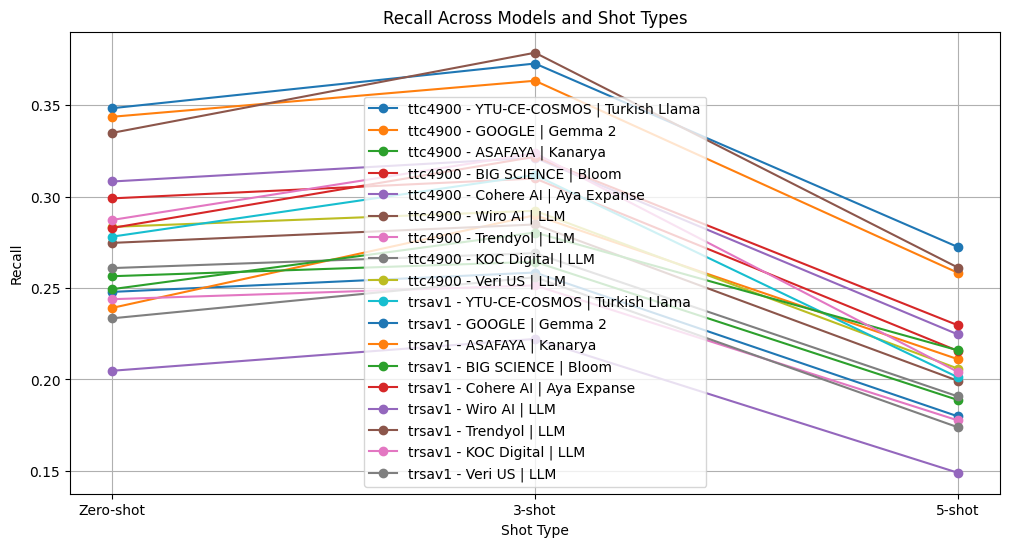

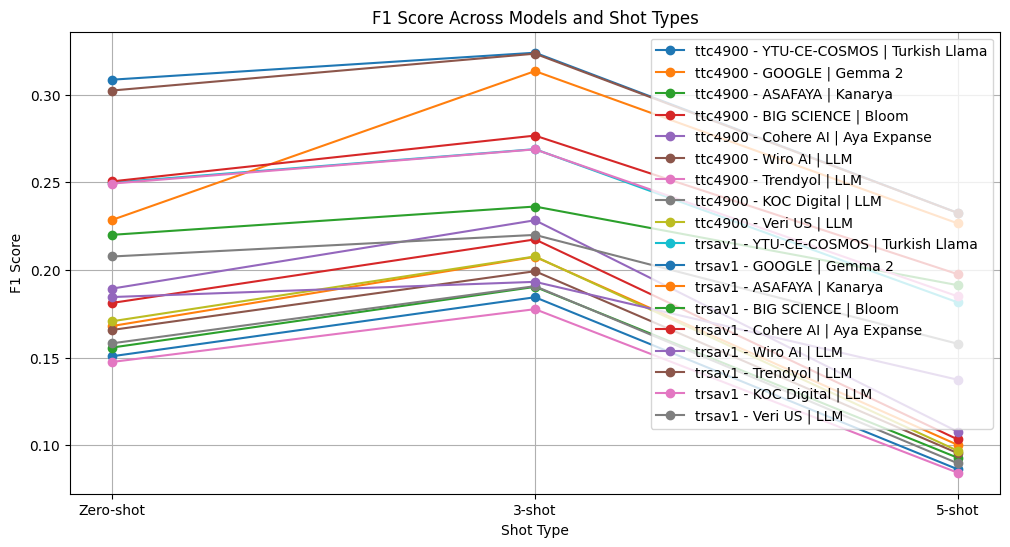

In [27]:
# görselleştirme
def plot_performance(performance_df, metric):
    plt.figure(figsize=(12, 6))
    for dataset_name in performance_df["Dataset"].unique():
        subset = performance_df[performance_df["Dataset"] == dataset_name]
        for model_name in subset["Model"].unique():
            model_subset = subset[subset["Model"] == model_name]
            plt.plot(
                model_subset["Shot Type"],
                model_subset[metric],
                marker="o",
                label=f"{dataset_name} - {model_name}"
            )

    plt.title(f"{metric} Across Models and Shot Types")
    plt.xlabel("Shot Type")
    plt.ylabel(metric)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

for metric in ["Accuracy", "Precision", "Recall", "F1 Score"]:
    plot_performance(performance_df, metric)